In [10]:
import rasterio as rio
from matplotlib import pyplot as plt
import hvplot.pandas
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import holoviews as hv
import matplotlib.colors as mcolors

In [11]:
# Open the file and get a file "handle"
landsat = rio.open("./LST.tiff")
landsat

<open DatasetReader name='./LST.tiff' mode='r'>

In [12]:
# All of the meta data
landsat.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 7741,
 'height': 7861,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(30.0, 0.0, 395385.0,
        0.0, -30.0, 4582215.0)}

In [13]:
# read the data of band1
data = landsat.read(1)
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
city_limits = gpd.read_file("/Users/tushimin/Desktop/week-4/data/City_Limits.geojson")

In [15]:
city_limits = city_limits.to_crs(landsat.crs.data['init'])

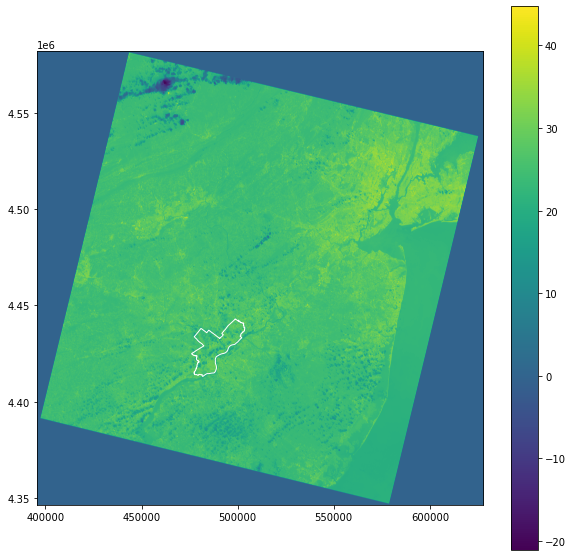

In [16]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
img = ax.imshow(
    data,
    extent=[  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ],
)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar
plt.colorbar(img)


In [17]:
from rasterio.mask import mask

In [18]:
# trim to philly city limits
masked, mask_transform = mask(
    dataset=landsat,
    shapes=city_limits.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

masked, mask_transform = mask(
    dataset=landsat,
    shapes=city_limits.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

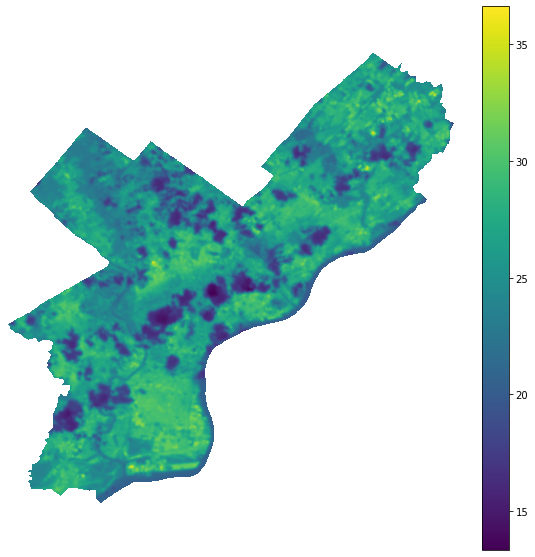

In [19]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first band
img = ax.imshow(masked[0], cmap="viridis", extent=[  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ],)

# Add a colorbar and turn off axis lines
plt.colorbar(img)
ax.set_axis_off()

In [20]:
# save cropped raster data
out_meta = landsat.meta
out_meta.update(
    {"height": masked.shape[1], "width": masked.shape[2], "transform": mask_transform}
)
print(out_meta)

# write small image to local Geotiff file
with rio.open("cropped_landsat.tif", "w", **out_meta) as dst:
    dst.write(masked)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 924, 'height': 1001, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 476055.0,
       0.0, -30.0, 4443075.0)}


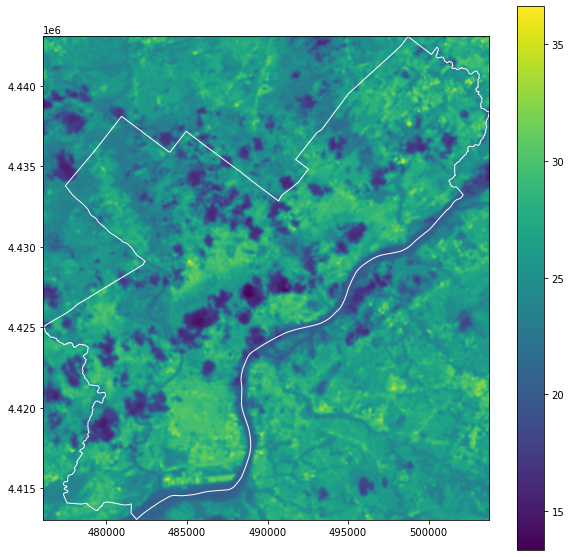

In [21]:
# check whether it goes well
landsat_philly = rio.open("./cropped_landsat.tif")
LST = landsat_philly.read(1)
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
img = ax.imshow(
    LST,
    extent=[  # Set the extent of the images
        landsat_philly.bounds.left,
        landsat_philly.bounds.right,
        landsat_philly.bounds.bottom,
        landsat_philly.bounds.top,
    ],
)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar
plt.colorbar(img)


In [22]:
from rasterstats import zonal_stats

In [23]:
vacant_land = gpd.read_file('/Users/tushimin/Desktop/MUSA550-final/data/Vacant_Indicators_Bldg-shp')

In [24]:
vacant_land.head()

,OBJECTID,ADDRESS,OWNER1,OWNER2,BLDG_DESC,OPA_ID,LNIADDRESS,COUNCILDIS,ZONINGBASE,ZIPCODE,BUILD_RANK,Shape__Are,Shape__Len,geometry
0,1,2736 N 5TH ST,TEJADA DIOMEDES,None,ROW W-OFF/STR 2STY MASONR,871526070,636911,7,CMX-2.5,19133,0.50,194.378906,69.611581,"POLYGON ((-75.14003 39.99338, -75.14004 39.993..."
1,2,2824 W ALBERT ST,LUCKEY MICHAEL,LUCKEY MARGARETTA,ROW 2 STY MASONRY,281330800,5998,5,RSA-5,19132,0.50,118.300781,52.899866,"POLYGON ((-75.17785 39.99593, -75.17791 39.995..."
2,3,5434 N MARVINE ST,PORCHEA GEORGE,None,ROW B/GAR 2STY MASONRY,493100900,417253,9,RSA-5,19141,0.67,198.535156,78.150764,"POLYGON ((-75.14124 40.03547, -75.14123 40.035..."
3,4,2636 N BOUVIER ST,HALL EUGENE JR,None,ROW 2 STY MASONRY,161242300,44574,5,RSA-5,19132,0.50,109.710938,49.635109,"POLYGON ((-75.16062 39.99397, -75.16063 39.993..."
4,5,4060 CHESTNUT ST,NARES APOSTOLOS,NARES ELIZABETH,APTS 5-50 UNTS MASONRY,881603100,81633,3,CMX-4,19104,0.50,403.542969,101.984291,"POLYGON ((-75.20460 39.95582, -75.20465 39.955..."


In [25]:
# Conver to landsat CRS
vacant_land = vacant_land.to_crs(landsat.crs.data['init'])

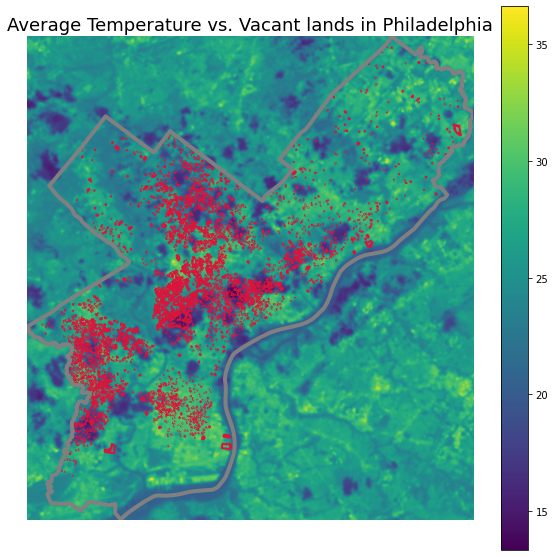

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot NDVI
img = ax.imshow(LST, extent=[  
        landsat_philly.bounds.left,
        landsat_philly.bounds.right,
        landsat_philly.bounds.bottom,
        landsat_philly.bounds.top,
    ],)

# NEW: add the parks
vacant_land.plot(ax=ax, edgecolor='crimson', facecolor='none', linewidth=2)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("Average Temperature vs. Vacant lands in Philadelphia", fontsize=18);

In [27]:
from rasterstats import zonal_stats

In [28]:
stats = zonal_stats(vacant_land, LST, affine=landsat_philly.transform, stats=['mean', 'median'])

/Users/tushimin/opt/anaconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [29]:
vacant_land['median_t'] = [s['median'] for s in stats] 

In [30]:
vacant_land_na = vacant_land.dropna(axis=0,how='any')

In [40]:
vacant_land_na.to_csv('vacant_land_na.csv',index=False)

In [31]:
len(vacant_land_na)

370

In [22]:
# fig, ax = plt.subplots(figsize=(10,10))

# # Plot NDVI


# # NEW: add the parks
# vacant_land_na.plot(ax=ax, edgecolor='crimson', facecolor='none', linewidth=2)

# # Format and plot city limits
# city_limits.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=4)


In [32]:
landcover = gpd.read_file('/Users/tushimin/Desktop/550-final/landcover_all')

In [33]:
# Conver to landsat CRS
landcover = landcover.to_crs(landsat.crs.data['init'])

In [34]:
len(landcover)

1464980

In [35]:
cover_test = landcover.head(1000000)
cover_test = cover_test.reset_index(drop=True)
cover_test

,Id,gridcode,Shape_Leng,Shape_Area,geometry
0,1,2,2.000000,0.250000,"POLYGON ((498719.757 4443058.687, 498719.761 4..."
1,2,2,16.012530,13.016906,"POLYGON ((498719.918 4443058.986, 498720.621 4..."
2,3,2,2.000000,0.250000,"POLYGON ((498719.600 4443058.539, 498719.604 4..."
3,4,2,2.000000,0.250000,"POLYGON ((498719.443 4443058.392, 498719.447 4..."
4,5,2,2.000000,0.250000,"POLYGON ((498719.281 4443058.092, 498719.286 4..."
...,...,...,...,...,...
999995,999996,7,39.170549,61.614266,"POLYGON ((489273.659 4425812.143, 489273.515 4..."
999996,999997,2,53.754771,106.315369,"POLYGON ((489628.593 4425801.090, 489628.352 4..."
999997,999998,1,73.165630,368.371590,"POLYGON ((489718.582 4425798.288, 489717.738 4..."
999998,999999,2,76.571319,224.653755,"POLYGON ((490323.537 4425779.449, 490323.019 4..."


In [ ]:
cover_test2 = landcover.tail(464980)
cover_test2

In [64]:
cover_test2 = landcover.tail(464980)
cover_test2

,Id,gridcode,Shape_Leng,Shape_Area,geometry
1000000,1000001,5,2.000000,2.500000e-01,"POLYGON ((490806.374 4425764.413, 490806.378 4..."
1000001,1000002,5,69.213036,2.794591e+02,"POLYGON ((490954.229 4425759.960, 490954.158 4..."
1000002,1000003,5,267.153604,2.525532e+03,"POLYGON ((477967.073 4426163.994, 477966.846 4..."
1000003,1000004,2,49.040103,7.397701e+01,"POLYGON ((478161.410 4426159.318, 478162.195 4..."
1000004,1000005,2,2.000000,2.500000e-01,"POLYGON ((478392.054 4426150.769, 478391.901 4..."
...,...,...,...,...,...
1464975,1464976,2,647.199237,1.426952e+04,"POLYGON ((479386.650 4413626.317, 479386.785 4..."
1464976,1464977,7,21.869778,2.468745e+01,"POLYGON ((481534.924 4413548.945, 481533.819 4..."
1464977,1464978,2,28163.999236,6.451945e+05,"POLYGON ((481527.546 4413532.257, 481527.837 4..."
1464978,1464979,7,202.779449,5.502836e+02,"POLYGON ((481526.768 4413517.040, 481527.052 4..."


In [36]:
intersection = gpd.overlay(vacant_land_na,cover_test, how="intersection")
intersection

,OBJECTID,ADDRESS,OWNER1,OWNER2,BLDG_DESC,OPA_ID,LNIADDRESS,COUNCILDIS,ZONINGBASE,ZIPCODE,BUILD_RANK,Shape__Are,Shape__Len,median_t,Id,gridcode,Shape_Leng,Shape_Area,geometry
0,78,5920 MAGNOLIA ST,HYATT WAYNE,BALLENTYNE-HYATT MICHELLE,ROW 2 STY MASONRY,592233300,406480,8,RSA-5,19144,0.5,139.656250,59.463487,22.095707,537891,5,229.070062,2075.479645,"POLYGON ((485372.964 4432710.786, 485372.298 4..."
1,78,5920 MAGNOLIA ST,HYATT WAYNE,BALLENTYNE-HYATT MICHELLE,ROW 2 STY MASONRY,592233300,406480,8,RSA-5,19144,0.5,139.656250,59.463487,22.095707,541257,2,725.974190,6062.816032,"POLYGON ((485370.301 4432707.383, 485366.732 4..."
2,78,5920 MAGNOLIA ST,HYATT WAYNE,BALLENTYNE-HYATT MICHELLE,ROW 2 STY MASONRY,592233300,406480,8,RSA-5,19144,0.5,139.656250,59.463487,22.095707,550898,7,2083.686644,10185.185935,"POLYGON ((485378.056 4432724.495, 485379.663 4..."
3,150,3427 PRINCETON AVE,KIEFER MARIE E,KIEFER VINCENT J,ROW B/GAR 2STY MASONRY,551400000,491401,6,RSA-5,19149,0.5,292.789062,101.164779,28.064859,595203,2,741.806236,4899.077637,"POLYGON ((496077.516 4431710.941, 496076.837 4..."
4,150,3427 PRINCETON AVE,KIEFER MARIE E,KIEFER VINCENT J,ROW B/GAR 2STY MASONRY,551400000,491401,6,RSA-5,19149,0.5,292.789062,101.164779,28.064859,595742,2,19.962364,13.645752,"POLYGON ((496067.096 4431696.862, 496066.597 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,8637,226 SUMAC ST,SCHEUERMANN ABIGAIL,SHAPANSKY MATTHEW,SEMI/DET 3 STY MASONRY,213021100,557513,4,RSA-3,19128,0.5,843.718750,141.855371,27.088984,781856,7,287.283973,1929.294563,"POLYGON ((482499.835 4429881.938, 482500.392 4..."
2075,8637,226 SUMAC ST,SCHEUERMANN ABIGAIL,SHAPANSKY MATTHEW,SEMI/DET 3 STY MASONRY,213021100,557513,4,RSA-3,19128,0.5,843.718750,141.855371,27.088984,782382,5,243.024137,2851.470315,"POLYGON ((482500.023 4429881.601, 482500.217 4..."
2076,8637,226 SUMAC ST,SCHEUERMANN ABIGAIL,SHAPANSKY MATTHEW,SEMI/DET 3 STY MASONRY,213021100,557513,4,RSA-3,19128,0.5,843.718750,141.855371,27.088984,782712,1,32.245439,70.305687,"POLYGON ((482513.499 4429857.411, 482514.594 4..."
2077,8637,226 SUMAC ST,SCHEUERMANN ABIGAIL,SHAPANSKY MATTHEW,SEMI/DET 3 STY MASONRY,213021100,557513,4,RSA-3,19128,0.5,843.718750,141.855371,27.088984,783973,1,549.816472,5101.232544,"MULTIPOLYGON (((482518.727 4429848.026, 482516..."


In [37]:
intersection.to_csv('intersection.csv', index=False)